In [1]:
!pip install "tensorflow-text>=2.11"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 37.7 MB/s eta 0:00:00


In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np

In [4]:
import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
from google.colab import files
import io

In [6]:
english_text = files.upload()

Saving aslg.test.en to aslg.test.en


In [7]:
processed_asl_gloss = files.upload()

Saving aslg.test_processed.gloss.asl to aslg.test_processed.gloss.asl


In [8]:
english_raw = english_text['aslg.test.en'].decode('utf-8').split('\n')

In [9]:
processed_asl_raw = processed_asl_gloss['aslg.test_processed.gloss.asl'].decode('utf-8').split('\n')

In [10]:
data_raw = dict(zip(english_raw, processed_asl_raw))

In [11]:
list(data_raw.items())[:10]

[('the date is not a fetish .', 'date be not fetish .'),
 ('the results speak for themselves .', 'result speak for mselves .'),
 ('it should mean that everyone is given an equal opportunity .',
  'it should mean that everyone be give equal opportunity .'),
 ('europe has done a very great deal of work in this field , which is to be welcomed .',
  'europe have do very great deal work in this field , which be to be welcome .'),
 ('we simply have to build it stage by stage .',
  'we simply have to build it stage by stage .'),
 ('it is an issue of proportionality .', 'it be issue proportionality .'),
 ('we are talking about rights , plurality and freedom .',
  'we be talk about rights , plurality and freedom .'),
 ('that attempt did not succeed , but it does represent a precedent for that kind of gathering .',
  'that attempt do not succeed , but it do represent precedent for that kind garing .'),
 ('this green paper is important , seeing as it concerns a matter that needs to be dealt with 

In [17]:
len(data_raw)

976

In [13]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [14]:
processed_asl_raw = np.array(processed_asl_raw)
english_raw = np.array(english_raw)

In [15]:
processed_asl_raw 

array(['date be not fetish .', 'result speak for mselves .',
       'it should mean that everyone be give equal opportunity .', ...,
       'that be vile misrepresentation .',
       'that be mostly in this part europe , where re be no emergency situation .',
       ''], dtype='<U163')

In [16]:
english_raw

array(['the date is not a fetish .', 'the results speak for themselves .',
       'it should mean that everyone is given an equal opportunity .',
       ..., 'that is a vile misrepresentation .',
       'that is mostly in this part of europe , where there is no emergency situation .',
       ''], dtype='<U179')

In [18]:
BUFFER_SIZE = len(english_raw)

In [19]:
BATCH_SIZE = 64

In [20]:
is_train = np.random.uniform(size=(len(processed_asl_raw),)) < 0.8

In [21]:
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((english_raw[is_train], processed_asl_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((english_raw[~is_train], processed_asl_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [22]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'however , we must not forget kosovo .'
 b'the commission has proposed the exemption of micro businesses from the european regulations on financial statements .'
 b'colleagues have spoken about the unprecedented flooding that took place in ireland at the weekend .'
 b'the present report is a typical example of the meddlesomeness and zeal for regulation that characterise the european parliament .'
 b'if europe does not restore its growth path , it will decline economically and will therefore also decline politically .'], shape=(5,), dtype=string)

tf.Tensor(
[b'however , we must not forget kosovo .'
 b'commission have propose exemption micro business from european regulation on financial statement .'
 b'colleague have speak about unprecedented flooding that take place in ireland at weekend .'
 b'present report be typical example meddlesomeness and zeal for regulation that characterise european parliament .'
 b'if europe do not restore its growth path , it will decline econo

In [23]:
example_text = tf.constant('if europe do not restore its growth path , it will decline economically and will refore also decline politically .')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'if europe do not restore its growth path , it will decline economically and will refore also decline politically .'
b'if europe do not restore its growth path , it will decline economically and will refore also decline politically .'


In [33]:
def tf_add_tokens(text):

  # text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  # text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  # text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  # text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [34]:
tf_add_tokens('if europe do not restore its growth path , it will decline economically and will refore also decline politically .')


<tf.Tensor: shape=(), dtype=string, numpy=b'[START] if europe do not restore its growth path , it will decline economically and will refore also decline politically . [END]'>

In [39]:
unique_words = set(' '.join(english_raw).split(' '))

In [40]:
len(unique_words)

2614

In [41]:
max_vocab_size = 2614

In [42]:
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_add_tokens,
    max_tokens=max_vocab_size,
    ragged=True)

In [43]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

In [47]:
context_text_processor.get_vocabulary()[40:60]

['very',
 'should',
 'see',
 'president',
 'minutes',
 'important',
 'about',
 'can',
 'commission',
 'report',
 'at',
 'these',
 'mr',
 'do',
 'they',
 'from',
 'all',
 'what',
 'europe',
 'was']

In [49]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_add_tokens,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[40:50]

['should',
 'report',
 'important',
 'about',
 'president',
 'commission',
 'at',
 'se',
 'or',
 'need']

In [50]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 62, 6, 15, 29, 21, 779, 287, 4, 3],
 [2, 5, 48, 26, 665, 5, 1812, 7, 1521, 529, 55, 5, 25, 641, 23, 98, 212, 4,
  3]                                                                       ,
 [2, 2054, 22, 1118, 46, 5, 990, 1768, 13, 577, 227, 11, 354, 50, 5, 949, 4,
  3]                                                                        ]>

In [51]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] however , we must not forget kosovo . [END]'

Text(0.5, 1.0, 'Mask')

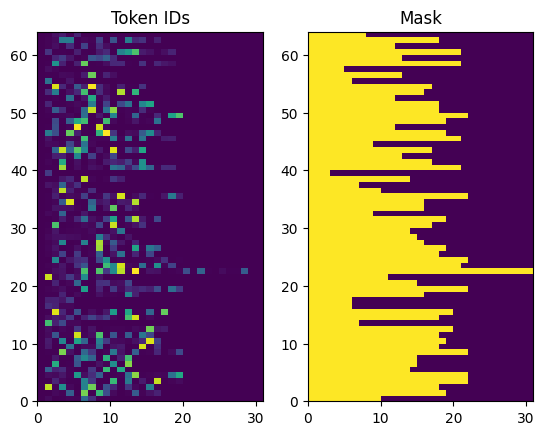

In [52]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [53]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [54]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  2  18  37  67   8 124  12 193 203  23]

[  2  13  34  65   7  68 201 176  18 287]
[ 13  34  65   7  68 201 176  18 287   8]


In [55]:
UNITS = 256

In [57]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(self.units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [58]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


In [59]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [60]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 20, 256)
Attention result, shape (batch, t, units): (64, 20, 256)
Attention weights, shape (batch, t, s):    (64, 20, 22)


In [61]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 0.9999999 , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.0000001 , 1.        , 1.0000001 , 1.0000001 , 1.0000001 ],
      dtype=float32)

Text(0.5, 1.0, 'Mask')

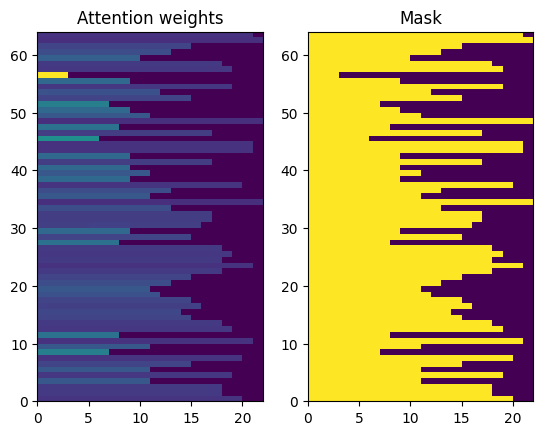

In [62]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask')

In [63]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [64]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [65]:
decoder = Decoder(target_text_processor, UNITS)

In [66]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 20)
logits shape shape: (batch, target_vocabulary_size) (64, 20, 1909)


In [67]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [68]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [69]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [70]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'have kelly constantly highly car priority meantime middle dalium win',
       b'sme maintain under common pick essential from current fifth middle',
       b'october dialogue ratify binding practice well defend organise again network'],
      dtype=object)

In [71]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [72]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 1909)


In [73]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [74]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [75]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [76]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.5543346, 'expected_acc': 0.0005238344683080147}

In [77]:
model.evaluate(val_ds, steps=20, return_dict=True)

 1/20 [>.............................] - ETA: 2:54 - loss: 7.5684 - masked_acc: 0.0000e+00 - masked_loss: 7.5684

20/20 [==============================] - 9s 6ms/step - loss: 7.5693 - masked_acc: 0.0000e+00 - masked_loss: 7.5688


{'loss': 7.569260120391846,
 'masked_acc': 0.0,
 'masked_loss': 7.568828105926514}

In [78]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 80,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
80/80 [==============================] - ETA: 0s - loss: 4.8608 - masked_acc: 0.2494 - masked_loss: 4.8543

80/80 [==============================] - 42s 308ms/step - loss: 4.8608 - masked_acc: 0.2494 - masked_loss: 4.8543 - val_loss: 4.9135 - val_masked_acc: 0.2998 - val_masked_loss: 4.9199
Epoch 2/100
79/80 [============================>.] - ETA: 0s - loss: 2.0249 - masked_acc: 0.6391 - masked_loss: 2.0247

80/80 [==============================] - 12s 149ms/step - loss: 2.0094 - masked_acc: 0.6419 - masked_loss: 2.0100
Epoch 3/100
80/80 [==============================] - ETA: 0s - loss: 0.3655 - masked_acc: 0.9685 - masked_loss: 0.3681

80/80 [==============================] - 8s 95ms/step - loss: 0.3655 - masked_acc: 0.9685 - masked_loss: 0.3681
Epoch 4/100
79/80 [============================>.] - ETA: 0s - loss: 0.0587 - masked_acc: 0.9993 - masked_loss: 0.0588

80/80 [==============================] - 8s 106ms/step - loss: 0.0583 - masked_acc: 0.9993 - masked_loss: 0.0584
Epoch 5/100
79/80 [============================>.] - ETA: 0s - loss: 0.0208 - masked_acc: 1.0000 - masked_loss: 0.0207

80/80 [==============================] - 5s 69ms/step - loss: 0.0207 - masked_acc: 1.0000 - masked_loss: 0.0207
Epoch 6/100
79/80 [============================>.] - ETA: 0s - loss: 0.0121 - masked_acc: 1.0000 - masked_loss: 0.0121

80/80 [==============================] - 4s 51ms/step - loss: 0.0121 - masked_acc: 1.0000 - masked_loss: 0.0121
Epoch 7/100
79/80 [============================>.] - ETA: 0s - loss: 0.2007 - masked_acc: 0.9626 - masked_loss: 0.2014

80/80 [==============================] - 5s 64ms/step - loss: 0.1984 - masked_acc: 0.9631 - masked_loss: 0.1992
Epoch 8/100
79/80 [============================>.] - ETA: 0s - loss: 0.0167 - masked_acc: 0.9999 - masked_loss: 0.0166

80/80 [==============================] - 4s 46ms/step - loss: 0.0166 - masked_acc: 0.9999 - masked_loss: 0.0165
Epoch 9/100
80/80 [==============================] - ETA: 0s - loss: 0.0086 - masked_acc: 1.0000 - masked_loss: 0.0087

80/80 [==============================] - 4s 46ms/step - loss: 0.0086 - masked_acc: 1.0000 - masked_loss: 0.0087
Epoch 10/100
79/80 [============================>.] - ETA: 0s - loss: 0.0061 - masked_acc: 1.0000 - masked_loss: 0.0061

80/80 [==============================] - 4s 51ms/step - loss: 0.0061 - masked_acc: 1.0000 - masked_loss: 0.0061
Epoch 11/100
79/80 [============================>.] - ETA: 0s - loss: 0.0046 - masked_acc: 1.0000 - masked_loss: 0.0046

80/80 [==============================] - 3s 43ms/step - loss: 0.0046 - masked_acc: 1.0000 - masked_loss: 0.0046
Epoch 12/100
79/80 [============================>.] - ETA: 0s - loss: 0.0037 - masked_acc: 1.0000 - masked_loss: 0.0037

80/80 [==============================] - 3s 38ms/step - loss: 0.0036 - masked_acc: 1.0000 - masked_loss: 0.0037
Epoch 13/100
79/80 [============================>.] - ETA: 0s - loss: 0.0030 - masked_acc: 1.0000 - masked_loss: 0.0030

80/80 [==============================] - 4s 55ms/step - loss: 0.0030 - masked_acc: 1.0000 - masked_loss: 0.0030
Epoch 14/100
78/80 [============================>.] - ETA: 0s - loss: 0.0025 - masked_acc: 1.0000 - masked_loss: 0.0025

80/80 [==============================] - 4s 47ms/step - loss: 0.0025 - masked_acc: 1.0000 - masked_loss: 0.0025
Epoch 15/100
78/80 [============================>.] - ETA: 0s - loss: 0.0021 - masked_acc: 1.0000 - masked_loss: 0.0021

80/80 [==============================] - 3s 33ms/step - loss: 0.0021 - masked_acc: 1.0000 - masked_loss: 0.0021
Epoch 16/100
79/80 [============================>.] - ETA: 0s - loss: 0.0018 - masked_acc: 1.0000 - masked_loss: 0.0018

80/80 [==============================] - 3s 32ms/step - loss: 0.0018 - masked_acc: 1.0000 - masked_loss: 0.0018
Epoch 17/100
80/80 [==============================] - ETA: 0s - loss: 0.0016 - masked_acc: 1.0000 - masked_loss: 0.0016

80/80 [==============================] - 4s 45ms/step - loss: 0.0016 - masked_acc: 1.0000 - masked_loss: 0.0016
Epoch 18/100
80/80 [==============================] - ETA: 0s - loss: 0.0014 - masked_acc: 1.0000 - masked_loss: 0.0014

80/80 [==============================] - 3s 41ms/step - loss: 0.0014 - masked_acc: 1.0000 - masked_loss: 0.0014
Epoch 19/100
80/80 [==============================] - ETA: 0s - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012

80/80 [==============================] - 3s 34ms/step - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012
Epoch 20/100
78/80 [============================>.] - ETA: 0s - loss: 0.0011 - masked_acc: 1.0000 - masked_loss: 0.0011

80/80 [==============================] - 3s 35ms/step - loss: 0.0011 - masked_acc: 1.0000 - masked_loss: 0.0011
Epoch 21/100
79/80 [============================>.] - ETA: 0s - loss: 0.0010 - masked_acc: 1.0000 - masked_loss: 9.9897e-04

80/80 [==============================] - 5s 69ms/step - loss: 9.9954e-04 - masked_acc: 1.0000 - masked_loss: 9.9767e-04
Epoch 22/100
80/80 [==============================] - ETA: 0s - loss: 9.0334e-04 - masked_acc: 1.0000 - masked_loss: 9.0477e-04

80/80 [==============================] - 6s 72ms/step - loss: 9.0334e-04 - masked_acc: 1.0000 - masked_loss: 9.0477e-04
Epoch 23/100
79/80 [============================>.] - ETA: 0s - loss: 8.1619e-04 - masked_acc: 1.0000 - masked_loss: 8.1566e-04

80/80 [==============================] - 3s 37ms/step - loss: 8.1593e-04 - masked_acc: 1.0000 - masked_loss: 8.1543e-04
Epoch 24/100
79/80 [============================>.] - ETA: 0s - loss: 7.4222e-04 - masked_acc: 1.0000 - masked_loss: 7.4154e-04

80/80 [==============================] - 5s 57ms/step - loss: 7.4211e-04 - masked_acc: 1.0000 - masked_loss: 7.4144e-04
Epoch 25/100
80/80 [==============================] - ETA: 0s - loss: 6.7672e-04 - masked_acc: 1.0000 - masked_loss: 6.7774e-04

80/80 [==============================] - 3s 32ms/step - loss: 6.7672e-04 - masked_acc: 1.0000 - masked_loss: 6.7774e-04
Epoch 26/100
79/80 [============================>.] - ETA: 0s - loss: 6.1953e-04 - masked_acc: 1.0000 - masked_loss: 6.1885e-04

80/80 [==============================] - 2s 27ms/step - loss: 6.1950e-04 - masked_acc: 1.0000 - masked_loss: 6.1877e-04
Epoch 27/100
79/80 [============================>.] - ETA: 0s - loss: 5.6899e-04 - masked_acc: 1.0000 - masked_loss: 5.6993e-04

80/80 [==============================] - 3s 32ms/step - loss: 5.6885e-04 - masked_acc: 1.0000 - masked_loss: 5.6978e-04
Epoch 28/100
80/80 [==============================] - ETA: 0s - loss: 5.2227e-04 - masked_acc: 1.0000 - masked_loss: 5.2124e-04

80/80 [==============================] - 3s 43ms/step - loss: 5.2227e-04 - masked_acc: 1.0000 - masked_loss: 5.2124e-04
Epoch 29/100
80/80 [==============================] - ETA: 0s - loss: 4.8250e-04 - masked_acc: 1.0000 - masked_loss: 4.8311e-04

80/80 [==============================] - 3s 32ms/step - loss: 4.8250e-04 - masked_acc: 1.0000 - masked_loss: 4.8311e-04
Epoch 30/100
80/80 [==============================] - ETA: 0s - loss: 4.4534e-04 - masked_acc: 1.0000 - masked_loss: 4.4511e-04

80/80 [==============================] - 2s 26ms/step - loss: 4.4534e-04 - masked_acc: 1.0000 - masked_loss: 4.4511e-04
Epoch 31/100
79/80 [============================>.] - ETA: 0s - loss: 4.1375e-04 - masked_acc: 1.0000 - masked_loss: 4.1270e-04

80/80 [==============================] - 2s 26ms/step - loss: 4.1378e-04 - masked_acc: 1.0000 - masked_loss: 4.1274e-04
Epoch 32/100
78/80 [============================>.] - ETA: 0s - loss: 3.8369e-04 - masked_acc: 1.0000 - masked_loss: 3.8252e-04

80/80 [==============================] - 2s 30ms/step - loss: 3.8322e-04 - masked_acc: 1.0000 - masked_loss: 3.8210e-04
Epoch 33/100
80/80 [==============================] - ETA: 0s - loss: 3.5606e-04 - masked_acc: 1.0000 - masked_loss: 3.5627e-04

80/80 [==============================] - 3s 35ms/step - loss: 3.5606e-04 - masked_acc: 1.0000 - masked_loss: 3.5627e-04
Epoch 34/100
80/80 [==============================] - ETA: 0s - loss: 3.3226e-04 - masked_acc: 1.0000 - masked_loss: 3.3072e-04

80/80 [==============================] - 4s 47ms/step - loss: 3.3226e-04 - masked_acc: 1.0000 - masked_loss: 3.3072e-04
Epoch 35/100
80/80 [==============================] - ETA: 0s - loss: 3.0858e-04 - masked_acc: 1.0000 - masked_loss: 3.0924e-04

80/80 [==============================] - 2s 26ms/step - loss: 3.0858e-04 - masked_acc: 1.0000 - masked_loss: 3.0924e-04
Epoch 36/100
80/80 [==============================] - ETA: 0s - loss: 2.8897e-04 - masked_acc: 1.0000 - masked_loss: 2.8937e-04

80/80 [==============================] - 2s 28ms/step - loss: 2.8897e-04 - masked_acc: 1.0000 - masked_loss: 2.8937e-04
Epoch 37/100
80/80 [==============================] - ETA: 0s - loss: 2.6993e-04 - masked_acc: 1.0000 - masked_loss: 2.7130e-04

80/80 [==============================] - 3s 32ms/step - loss: 2.6993e-04 - masked_acc: 1.0000 - masked_loss: 2.7130e-04
Epoch 38/100
79/80 [============================>.] - ETA: 0s - loss: 0.2130 - masked_acc: 0.9471 - masked_loss: 0.2115

80/80 [==============================] - 4s 48ms/step - loss: 0.2138 - masked_acc: 0.9469 - masked_loss: 0.2123
Epoch 39/100
80/80 [==============================] - ETA: 0s - loss: 0.0317 - masked_acc: 0.9933 - masked_loss: 0.0334

80/80 [==============================] - 2s 30ms/step - loss: 0.0317 - masked_acc: 0.9933 - masked_loss: 0.0334
Epoch 40/100
79/80 [============================>.] - ETA: 0s - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020

80/80 [==============================] - 3s 32ms/step - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020
Epoch 41/100
80/80 [==============================] - ETA: 0s - loss: 0.0013 - masked_acc: 1.0000 - masked_loss: 0.0013

80/80 [==============================] - 2s 27ms/step - loss: 0.0013 - masked_acc: 1.0000 - masked_loss: 0.0013
Epoch 42/100
79/80 [============================>.] - ETA: 0s - loss: 0.0010 - masked_acc: 1.0000 - masked_loss: 0.0010

80/80 [==============================] - 2s 31ms/step - loss: 0.0010 - masked_acc: 1.0000 - masked_loss: 0.0010
Epoch 43/100
79/80 [============================>.] - ETA: 0s - loss: 8.5268e-04 - masked_acc: 1.0000 - masked_loss: 8.5272e-04

80/80 [==============================] - 3s 42ms/step - loss: 8.5157e-04 - masked_acc: 1.0000 - masked_loss: 8.5167e-04
Epoch 44/100
79/80 [============================>.] - ETA: 0s - loss: 7.1921e-04 - masked_acc: 1.0000 - masked_loss: 7.1750e-04

80/80 [==============================] - 2s 29ms/step - loss: 7.1806e-04 - masked_acc: 1.0000 - masked_loss: 7.1643e-04
Epoch 45/100
78/80 [============================>.] - ETA: 0s - loss: 6.2341e-04 - masked_acc: 1.0000 - masked_loss: 6.2298e-04

80/80 [==============================] - 2s 30ms/step - loss: 6.2325e-04 - masked_acc: 1.0000 - masked_loss: 6.2284e-04
Epoch 46/100
78/80 [============================>.] - ETA: 0s - loss: 5.4635e-04 - masked_acc: 1.0000 - masked_loss: 5.4500e-04

80/80 [==============================] - 3s 35ms/step - loss: 5.4566e-04 - masked_acc: 1.0000 - masked_loss: 5.4480e-04
Epoch 47/100
78/80 [============================>.] - ETA: 0s - loss: 4.8662e-04 - masked_acc: 1.0000 - masked_loss: 4.8623e-04

80/80 [==============================] - 2s 27ms/step - loss: 4.8604e-04 - masked_acc: 1.0000 - masked_loss: 4.8569e-04
Epoch 48/100
79/80 [============================>.] - ETA: 0s - loss: 4.3507e-04 - masked_acc: 1.0000 - masked_loss: 4.3513e-04

80/80 [==============================] - 3s 42ms/step - loss: 4.3435e-04 - masked_acc: 1.0000 - masked_loss: 4.3444e-04
Epoch 49/100
79/80 [============================>.] - ETA: 0s - loss: 3.9384e-04 - masked_acc: 1.0000 - masked_loss: 3.9374e-04

80/80 [==============================] - 2s 27ms/step - loss: 3.9367e-04 - masked_acc: 1.0000 - masked_loss: 3.9358e-04
Epoch 50/100
79/80 [============================>.] - ETA: 0s - loss: 3.5638e-04 - masked_acc: 1.0000 - masked_loss: 3.5690e-04

80/80 [==============================] - 2s 28ms/step - loss: 3.5619e-04 - masked_acc: 1.0000 - masked_loss: 3.5672e-04
Epoch 51/100
79/80 [============================>.] - ETA: 0s - loss: 3.2628e-04 - masked_acc: 1.0000 - masked_loss: 3.2572e-04

80/80 [==============================] - 2s 28ms/step - loss: 3.2625e-04 - masked_acc: 1.0000 - masked_loss: 3.2571e-04
Epoch 52/100
79/80 [============================>.] - ETA: 0s - loss: 2.9962e-04 - masked_acc: 1.0000 - masked_loss: 2.9929e-04

80/80 [==============================] - 2s 26ms/step - loss: 2.9952e-04 - masked_acc: 1.0000 - masked_loss: 2.9894e-04
Epoch 53/100
80/80 [==============================] - ETA: 0s - loss: 2.7602e-04 - masked_acc: 1.0000 - masked_loss: 2.7606e-04

80/80 [==============================] - 4s 46ms/step - loss: 2.7602e-04 - masked_acc: 1.0000 - masked_loss: 2.7606e-04
Epoch 54/100
80/80 [==============================] - ETA: 0s - loss: 2.5447e-04 - masked_acc: 1.0000 - masked_loss: 2.5509e-04

80/80 [==============================] - 3s 35ms/step - loss: 2.5447e-04 - masked_acc: 1.0000 - masked_loss: 2.5509e-04
Epoch 55/100
80/80 [==============================] - ETA: 0s - loss: 2.3648e-04 - masked_acc: 1.0000 - masked_loss: 2.3648e-04

80/80 [==============================] - 3s 31ms/step - loss: 2.3648e-04 - masked_acc: 1.0000 - masked_loss: 2.3648e-04
Epoch 56/100
79/80 [============================>.] - ETA: 0s - loss: 2.1887e-04 - masked_acc: 1.0000 - masked_loss: 2.1898e-04

80/80 [==============================] - 2s 28ms/step - loss: 2.1872e-04 - masked_acc: 1.0000 - masked_loss: 2.1883e-04
Epoch 57/100
80/80 [==============================] - ETA: 0s - loss: 2.0437e-04 - masked_acc: 1.0000 - masked_loss: 2.0398e-04

80/80 [==============================] - 2s 27ms/step - loss: 2.0437e-04 - masked_acc: 1.0000 - masked_loss: 2.0398e-04
Epoch 58/100
80/80 [==============================] - ETA: 0s - loss: 1.9039e-04 - masked_acc: 1.0000 - masked_loss: 1.8986e-04

80/80 [==============================] - 3s 43ms/step - loss: 1.9039e-04 - masked_acc: 1.0000 - masked_loss: 1.8986e-04
Epoch 59/100
80/80 [==============================] - ETA: 0s - loss: 1.7796e-04 - masked_acc: 1.0000 - masked_loss: 1.7756e-04

80/80 [==============================] - 2s 30ms/step - loss: 1.7796e-04 - masked_acc: 1.0000 - masked_loss: 1.7756e-04
Epoch 60/100
80/80 [==============================] - ETA: 0s - loss: 1.6711e-04 - masked_acc: 1.0000 - masked_loss: 1.6600e-04

80/80 [==============================] - 2s 26ms/step - loss: 1.6711e-04 - masked_acc: 1.0000 - masked_loss: 1.6600e-04
Epoch 61/100
80/80 [==============================] - ETA: 0s - loss: 1.5634e-04 - masked_acc: 1.0000 - masked_loss: 1.5646e-04

80/80 [==============================] - 3s 37ms/step - loss: 1.5634e-04 - masked_acc: 1.0000 - masked_loss: 1.5646e-04
Epoch 62/100
79/80 [============================>.] - ETA: 0s - loss: 1.4719e-04 - masked_acc: 1.0000 - masked_loss: 1.4734e-04

80/80 [==============================] - 3s 43ms/step - loss: 1.4714e-04 - masked_acc: 1.0000 - masked_loss: 1.4729e-04
Epoch 63/100
79/80 [============================>.] - ETA: 0s - loss: 1.3839e-04 - masked_acc: 1.0000 - masked_loss: 1.3829e-04

80/80 [==============================] - 3s 33ms/step - loss: 1.3829e-04 - masked_acc: 1.0000 - masked_loss: 1.3820e-04
Epoch 64/100
80/80 [==============================] - ETA: 0s - loss: 1.3004e-04 - masked_acc: 1.0000 - masked_loss: 1.3064e-04

80/80 [==============================] - 2s 27ms/step - loss: 1.3004e-04 - masked_acc: 1.0000 - masked_loss: 1.3064e-04
Epoch 65/100
80/80 [==============================] - ETA: 0s - loss: 1.2267e-04 - masked_acc: 1.0000 - masked_loss: 1.2281e-04

80/80 [==============================] - 2s 26ms/step - loss: 1.2267e-04 - masked_acc: 1.0000 - masked_loss: 1.2281e-04
Epoch 66/100
79/80 [============================>.] - ETA: 0s - loss: 1.1578e-04 - masked_acc: 1.0000 - masked_loss: 1.1588e-04

80/80 [==============================] - 2s 26ms/step - loss: 1.1580e-04 - masked_acc: 1.0000 - masked_loss: 1.1589e-04
Epoch 67/100
80/80 [==============================] - ETA: 0s - loss: 1.0921e-04 - masked_acc: 1.0000 - masked_loss: 1.0934e-04

80/80 [==============================] - 3s 33ms/step - loss: 1.0921e-04 - masked_acc: 1.0000 - masked_loss: 1.0934e-04
Epoch 68/100
80/80 [==============================] - ETA: 0s - loss: 1.0282e-04 - masked_acc: 1.0000 - masked_loss: 1.0274e-04

80/80 [==============================] - 4s 40ms/step - loss: 1.0282e-04 - masked_acc: 1.0000 - masked_loss: 1.0274e-04
Epoch 69/100
80/80 [==============================] - ETA: 0s - loss: 9.7891e-05 - masked_acc: 1.0000 - masked_loss: 9.7724e-05

80/80 [==============================] - 2s 27ms/step - loss: 9.7891e-05 - masked_acc: 1.0000 - masked_loss: 9.7724e-05
Epoch 70/100
78/80 [============================>.] - ETA: 0s - loss: 9.2457e-05 - masked_acc: 1.0000 - masked_loss: 9.2547e-05

80/80 [==============================] - 3s 34ms/step - loss: 9.2424e-05 - masked_acc: 1.0000 - masked_loss: 9.2513e-05
Epoch 71/100
79/80 [============================>.] - ETA: 0s - loss: 8.7351e-05 - masked_acc: 1.0000 - masked_loss: 8.7234e-05

80/80 [==============================] - 2s 27ms/step - loss: 8.7255e-05 - masked_acc: 1.0000 - masked_loss: 8.7145e-05
Epoch 72/100
80/80 [==============================] - ETA: 0s - loss: 8.2869e-05 - masked_acc: 1.0000 - masked_loss: 8.3176e-05

80/80 [==============================] - 3s 35ms/step - loss: 8.2869e-05 - masked_acc: 1.0000 - masked_loss: 8.3176e-05
Epoch 73/100
80/80 [==============================] - ETA: 0s - loss: 7.8692e-05 - masked_acc: 1.0000 - masked_loss: 7.8713e-05

80/80 [==============================] - 3s 36ms/step - loss: 7.8692e-05 - masked_acc: 1.0000 - masked_loss: 7.8713e-05
Epoch 74/100
80/80 [==============================] - ETA: 0s - loss: 7.4600e-05 - masked_acc: 1.0000 - masked_loss: 7.4412e-05

80/80 [==============================] - 2s 26ms/step - loss: 7.4600e-05 - masked_acc: 1.0000 - masked_loss: 7.4412e-05
Epoch 75/100
80/80 [==============================] - ETA: 0s - loss: 7.0817e-05 - masked_acc: 1.0000 - masked_loss: 7.0583e-05

80/80 [==============================] - 2s 26ms/step - loss: 7.0817e-05 - masked_acc: 1.0000 - masked_loss: 7.0583e-05
Epoch 76/100
79/80 [============================>.] - ETA: 0s - loss: 6.7156e-05 - masked_acc: 1.0000 - masked_loss: 6.7037e-05

80/80 [==============================] - 2s 26ms/step - loss: 6.7123e-05 - masked_acc: 1.0000 - masked_loss: 6.7007e-05
Epoch 77/100
80/80 [==============================] - ETA: 0s - loss: 6.3883e-05 - masked_acc: 1.0000 - masked_loss: 6.3832e-05

80/80 [==============================] - 2s 26ms/step - loss: 6.3883e-05 - masked_acc: 1.0000 - masked_loss: 6.3832e-05
Epoch 78/100
79/80 [============================>.] - ETA: 0s - loss: 6.0791e-05 - masked_acc: 1.0000 - masked_loss: 6.0947e-05

80/80 [==============================] - 3s 41ms/step - loss: 6.0750e-05 - masked_acc: 1.0000 - masked_loss: 6.0803e-05
Epoch 79/100
79/80 [============================>.] - ETA: 0s - loss: 5.7729e-05 - masked_acc: 1.0000 - masked_loss: 5.7443e-05

80/80 [==============================] - 2s 26ms/step - loss: 5.7705e-05 - masked_acc: 1.0000 - masked_loss: 5.7424e-05
Epoch 80/100
80/80 [==============================] - ETA: 0s - loss: 5.5098e-05 - masked_acc: 1.0000 - masked_loss: 5.5277e-05

80/80 [==============================] - 2s 27ms/step - loss: 5.5098e-05 - masked_acc: 1.0000 - masked_loss: 5.5277e-05
Epoch 81/100
79/80 [============================>.] - ETA: 0s - loss: 5.2217e-05 - masked_acc: 1.0000 - masked_loss: 5.2212e-05

80/80 [==============================] - 2s 26ms/step - loss: 5.2229e-05 - masked_acc: 1.0000 - masked_loss: 5.2223e-05
Epoch 82/100
80/80 [==============================] - ETA: 0s - loss: 4.9780e-05 - masked_acc: 1.0000 - masked_loss: 4.9807e-05

80/80 [==============================] - 3s 32ms/step - loss: 4.9780e-05 - masked_acc: 1.0000 - masked_loss: 4.9807e-05
Epoch 83/100
79/80 [============================>.] - ETA: 0s - loss: 4.7393e-05 - masked_acc: 1.0000 - masked_loss: 4.7146e-05

80/80 [==============================] - 4s 44ms/step - loss: 4.7326e-05 - masked_acc: 1.0000 - masked_loss: 4.7085e-05
Epoch 84/100
80/80 [==============================] - ETA: 0s - loss: 4.5164e-05 - masked_acc: 1.0000 - masked_loss: 4.5349e-05

80/80 [==============================] - 2s 26ms/step - loss: 4.5164e-05 - masked_acc: 1.0000 - masked_loss: 4.5349e-05
Epoch 85/100
79/80 [============================>.] - ETA: 0s - loss: 4.3048e-05 - masked_acc: 1.0000 - masked_loss: 4.3021e-05

80/80 [==============================] - 2s 26ms/step - loss: 4.3071e-05 - masked_acc: 1.0000 - masked_loss: 4.3042e-05
Epoch 86/100
80/80 [==============================] - ETA: 0s - loss: 4.1009e-05 - masked_acc: 1.0000 - masked_loss: 4.0893e-05

80/80 [==============================] - 2s 29ms/step - loss: 4.1009e-05 - masked_acc: 1.0000 - masked_loss: 4.0893e-05
Epoch 87/100
80/80 [==============================] - ETA: 0s - loss: 3.9122e-05 - masked_acc: 1.0000 - masked_loss: 3.9188e-05

80/80 [==============================] - 3s 32ms/step - loss: 3.9122e-05 - masked_acc: 1.0000 - masked_loss: 3.9188e-05
Epoch 88/100
79/80 [============================>.] - ETA: 0s - loss: 3.7202e-05 - masked_acc: 1.0000 - masked_loss: 3.7114e-05

80/80 [==============================] - 3s 42ms/step - loss: 3.7238e-05 - masked_acc: 1.0000 - masked_loss: 3.7149e-05
Epoch 89/100
80/80 [==============================] - ETA: 0s - loss: 3.5507e-05 - masked_acc: 1.0000 - masked_loss: 3.5536e-05

80/80 [==============================] - 2s 29ms/step - loss: 3.5507e-05 - masked_acc: 1.0000 - masked_loss: 3.5536e-05
Epoch 90/100
78/80 [============================>.] - ETA: 0s - loss: 3.3940e-05 - masked_acc: 1.0000 - masked_loss: 3.3847e-05

80/80 [==============================] - 2s 26ms/step - loss: 3.3892e-05 - masked_acc: 1.0000 - masked_loss: 3.3803e-05
Epoch 91/100
79/80 [============================>.] - ETA: 0s - loss: 3.2424e-05 - masked_acc: 1.0000 - masked_loss: 3.2567e-05

80/80 [==============================] - 2s 26ms/step - loss: 3.2392e-05 - masked_acc: 1.0000 - masked_loss: 3.2452e-05
Epoch 92/100
79/80 [============================>.] - ETA: 0s - loss: 3.0857e-05 - masked_acc: 1.0000 - masked_loss: 3.0889e-05

80/80 [==============================] - 2s 26ms/step - loss: 3.0842e-05 - masked_acc: 1.0000 - masked_loss: 3.0874e-05
Epoch 93/100
80/80 [==============================] - ETA: 0s - loss: 2.9501e-05 - masked_acc: 1.0000 - masked_loss: 2.9436e-05

80/80 [==============================] - 3s 33ms/step - loss: 2.9501e-05 - masked_acc: 1.0000 - masked_loss: 2.9436e-05
Epoch 94/100
79/80 [============================>.] - ETA: 0s - loss: 2.8170e-05 - masked_acc: 1.0000 - masked_loss: 2.8066e-05

80/80 [==============================] - 3s 33ms/step - loss: 2.8155e-05 - masked_acc: 1.0000 - masked_loss: 2.8054e-05
Epoch 95/100
80/80 [==============================] - ETA: 0s - loss: 2.6929e-05 - masked_acc: 1.0000 - masked_loss: 2.6969e-05

80/80 [==============================] - 2s 27ms/step - loss: 2.6929e-05 - masked_acc: 1.0000 - masked_loss: 2.6969e-05
Epoch 96/100
80/80 [==============================] - ETA: 0s - loss: 2.5628e-05 - masked_acc: 1.0000 - masked_loss: 2.5562e-05

80/80 [==============================] - 2s 29ms/step - loss: 2.5628e-05 - masked_acc: 1.0000 - masked_loss: 2.5562e-05
Epoch 97/100
79/80 [============================>.] - ETA: 0s - loss: 2.4567e-05 - masked_acc: 1.0000 - masked_loss: 2.4570e-05

80/80 [==============================] - 3s 43ms/step - loss: 2.4579e-05 - masked_acc: 1.0000 - masked_loss: 2.4581e-05
Epoch 98/100
80/80 [==============================] - ETA: 0s - loss: 2.3407e-05 - masked_acc: 1.0000 - masked_loss: 2.3429e-05

80/80 [==============================] - 3s 43ms/step - loss: 2.3407e-05 - masked_acc: 1.0000 - masked_loss: 2.3429e-05
Epoch 99/100
80/80 [==============================] - ETA: 0s - loss: 2.2431e-05 - masked_acc: 1.0000 - masked_loss: 2.2500e-05

80/80 [==============================] - 2s 28ms/step - loss: 2.2431e-05 - masked_acc: 1.0000 - masked_loss: 2.2500e-05
Epoch 100/100
80/80 [==============================] - ETA: 0s - loss: 2.1366e-05 - masked_acc: 1.0000 - masked_loss: 2.1381e-05

80/80 [==============================] - 2s 26ms/step - loss: 2.1366e-05 - masked_acc: 1.0000 - masked_loss: 2.1381e-05


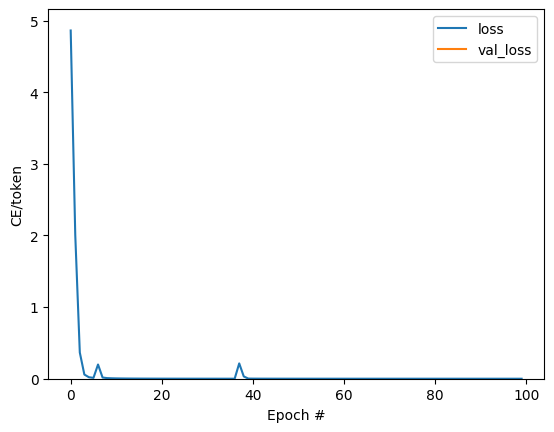

In [79]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

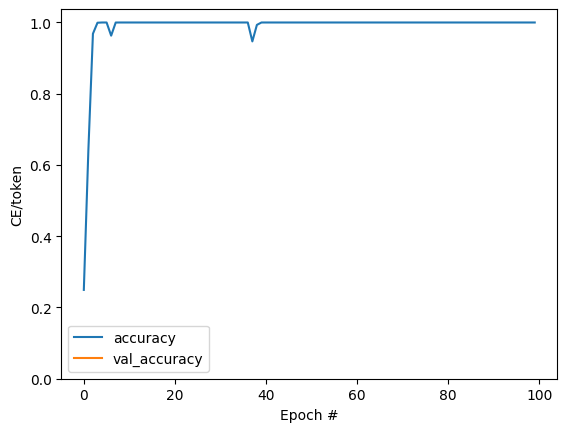

In [80]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [81]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [85]:
result = model.translate(['i am grateful for all your speeches .'])
result[0].numpy().decode()

'i be grateful for all you speech . '

In [88]:
import random

In [91]:
random.choice(list(data_raw.items()))

("i voted in favour of the motion for a european parliament resolution on turkey's progress report 200the report unfortunately comprises both serious lacks and misdirected demands .",
 'i vote in favor motion for european parliament resolution on turkey poss progress report 200 report unfortunately comprise both serious lack and misdirect demand .')

In [94]:
model.translate(["i voted in favour of the motion for a european parliament resolution on turkey's progress report 200the report unfortunately comprises both serious lacks and misdirected demands ."])[0].numpy().decode()

'i vote in favor motion for european parliament resolution on turkey poss progress report 200 report unfortunately comprise both serious lack and misdirect demand . '

In [131]:
"america" in unique_words

True

In [97]:
def translate(text):
  return model.translate([text])[0].numpy().decode()

In [138]:
translate("i like parliament .")

'i like to parliament . '

In [141]:
freq = {}
for word in ' '.join(english_raw).split(' '):
  if word in freq:
    freq[word] += 1
  else:
    freq[word] = 0

In [142]:
freq

{'the': 810,
 'date': 1,
 'is': 297,
 'not': 103,
 'a': 208,
 'fetish': 0,
 '.': 866,
 'results': 1,
 'speak': 2,
 'for': 140,
 'themselves': 3,
 'it': 137,
 'should': 36,
 'mean': 3,
 'that': 211,
 'everyone': 5,
 'given': 4,
 'an': 40,
 'equal': 1,
 'opportunity': 3,
 'europe': 26,
 'has': 61,
 'done': 6,
 'very': 38,
 'great': 12,
 'deal': 3,
 'of': 377,
 'work': 16,
 'in': 243,
 'this': 214,
 'field': 0,
 ',': 417,
 'which': 27,
 'to': 355,
 'be': 110,
 'welcomed': 0,
 'we': 192,
 'simply': 5,
 'have': 89,
 'build': 1,
 'stage': 2,
 'by': 42,
 'issue': 13,
 'proportionality': 0,
 'are': 104,
 'talking': 3,
 'about': 33,
 'rights': 9,
 'plurality': 0,
 'and': 246,
 'freedom': 1,
 'attempt': 0,
 'did': 6,
 'succeed': 1,
 'but': 19,
 'does': 15,
 'represent': 0,
 'precedent': 0,
 'kind': 2,
 'gathering': 0,
 'green': 1,
 'paper': 1,
 'important': 34,
 'seeing': 1,
 'as': 58,
 'concerns': 6,
 'matter': 6,
 'needs': 14,
 'dealt': 3,
 'with': 57,
 'mr': 27,
 'audy': 0,
 'asked': 5,
 'fol